In [3]:
%pylab inline

from qampy.core import io
from qampy import signals,impairments,helpers,equalisation,io, filtering,phaserec, helpers
from qampy.core import impairments as impair
from qampy.core import digital_pre_compensation as dpc
from scipy import signal

# plot 1-D signal
def plot_1d(mysig):
    figure(figsize=(6,6))
    plot(mysig.real.flatten(),mysig.imag.flatten(),'b.')
    axis("square")
    # xticks([])
    # yticks([])
    # axis([-1.5,1.5,-1.5,1.5])
    title("Complete Frame")
    show()
    
def pilot_rxDSP(sig_h, roll_off, tap_num=31, mu=1e-2, shiftfac=9992):
    # Rx
    rxsig = sig_h.resample(2*sig_h.fb, beta=roll_off, renormalise=True)
    rxsig = helpers.normalise_and_center(rxsig)
    
    # rxsig.sync2frame()
    rxsig.shiftfctrs = np.array([shiftfac], dtype='int')
    rxsig.synctaps = 17
    eq_sig = equalisation.pilot_equalizer(rxsig,(mu, mu), tap_num,foe_comp=False,methods=("mcma","mddma"), adaptive_stepsize=True)
    cpe_sig = phaserec.pilot_cpe(eq_sig[1],N=5,use_seq=False)
    receive_sig = cpe_sig[0]
    receive_payload = receive_sig.get_data()
    SER = receive_payload.cal_ser()
    return SER, receive_sig

Populating the interactive namespace from numpy and matplotlib


In [4]:
def sim_channel_and_rxDSP(sig_delay, arc_arr, vpp_arr, clip_lvl, noise_var, enob=5):

    PAPR_sig_delay = (abs(sig_delay.real)**2).max()/(abs(sig_delay.real)**2).mean()

    # arcsin()
    arc_swing = arc_arr
    sig_arc_swi = helpers.rescale_signal(sig_delay, 1) * arc_swing
    sig_arc = dpc.modulator_arsin(sig_arc_swi, 3.5)
    PAPR_sig_arc = (abs(sig_arc.real)**2).max()/(abs(sig_arc.real)**2).mean()

#     # dac freq comp
#     p_f = dpc.dac_freq_comp(sig_delay.fb, sig_delay.shape[1], roll_off, PAPR_sig_arc, prms_dac=(16e9, 2, 'sos', enob))
#     sig_f = np.fft.fft(sig_arc)
#     sig_comp = np.fft.ifft( sig_f * np.atleast_2d(p_f) )
#     sig_comp = sig_delay.recreate_from_np_array(sig_comp)
#     PAPR_sig_comp = (abs(sig_comp.real)**2).max()/(abs(sig_comp.real)**2).mean()

    # clipping
    res_volt = clip_lvl
    sig_res = helpers.rescale_signal(sig_arc, res_volt) 
    sig_clip = dpc.clipper(sig_res,1)
    PAPR_sig_clip = (abs(sig_clip.real)**2).max()/(abs(sig_clip.real)**2).mean()

    # Quantizer
    sigq = impair.quantize_signal_New(sig_clip, nbits=8, rescale_in=True, rescale_out=True)
    sig_dac_out, sig_enob_noise, snr_enob = impair.sim_DAC_response(sigq, sigq.fs, enob, 16e9, quantizer_model=True)
    sig_dac_out = sig_delay.recreate_from_np_array(sig_enob_noise)        

    # amp and mod response
    amp_volt = vpp_arr/2
    sig_amp_out = impair.ideal_amplifier_response(sig_dac_out, amp_volt)
    sig_mod_out = impairments.sim_mod_response(sig_amp_out)

    # Add fixed noise
    sig_rx = impairments.add_awgn(sig_mod_out, np.sqrt(noise_var * 2))

    # Rx 
    SER, receive_sig = pilot_rxDSP(sig_rx, roll_off=0.1)
            
    return SER, receive_sig

In [5]:
M = 64                  # modulation format
pilot_seq_len = 1024    # pilot squence length, notice:phase pilots are not included 
pilot_ins_rat = 32      # i.e. for every 32 symbol, one phase pilot symbol is inserted 
N = 2**18               # total sequence length (Sequenc pilot + phase pilot + payload)
nmodes = 1              # number of polarization mode
fb = 40e9               # symbol rate
N_pl = int( (N-pilot_seq_len)*(pilot_ins_rat-1)/pilot_ins_rat )  # payload sequence length

pilot_sig = signals.SignalWithPilots(M, N, pilot_seq_len, pilot_ins_rat, nmodes=nmodes, Mpilots=4, nframes=2, fb=fb)

roll_off = 0.1   # roll-off factor of rrc filter
os_rate = 2      # over-sampling rate
pilot_sigResam = pilot_sig.resample(os_rate*pilot_sig.fb, beta=roll_off)

delay = 10000    # delay 10000 symbol on purpose of synchronization
sig_delay = np.roll(pilot_sigResam,delay,axis=-1)

PAPR_sigResam = (abs(sig_delay.real)**2).max()/(abs(sig_delay.real)**2).mean()
print('PAPR of sig_delay is %f'%PAPR_sigResam)

PAPR of sig_delay is 9.720449


In [6]:
snr_tar = 28
noise_var = 10**(-13.6/10)/10**(snr_tar/10)

# Without Compensation

In [12]:
arc_arr = np.linspace(1, 1, 1)
vpp_arr = np.linspace(0.2, 1.2, 11)*7
power_out_pilot_ori = np.zeros((arc_arr.shape[0],vpp_arr.shape[0]))
SER_pilot_ori = np.zeros((arc_arr.shape[0],vpp_arr.shape[0]))
BER_pilot_ori = np.zeros((arc_arr.shape[0],vpp_arr.shape[0]))

sig_res = helpers.rescale_signal(sig_delay, 1)
for i in range(arc_arr.shape[0]):
    
    enob = 5
    
    # Quantizer
    sigq = impair.quantize_signal_New(sig_res, nbits=8, rescale_in=True, rescale_out=True)
    sig_dac_out, sig_enob_noise, snr_enob = impair.sim_DAC_response(sigq, sigq.fs, enob, 16e9, quantizer_model=True)
    sig_dac_out = pilot_sigResam.recreate_from_np_array(sig_enob_noise)        
    
    for j in range(vpp_arr.shape[0]):
        
        # amp and mod response
        amp_volt = vpp_arr[j]/2
        sig_amp_out = impair.ideal_amplifier_response(sig_dac_out, amp_volt)
        sig_mod_out = impairments.sim_mod_response(sig_amp_out)

        p_in = 0
        power_out_pilot_ori[i, j] = 10 * np.log10(abs(sig_mod_out*np.conj(sig_mod_out)).mean() * (10 ** (p_in / 10))) 
        
        # Add fixed noise
        sig_rx = impairments.add_awgn(sig_mod_out, np.sqrt(noise_var * 2))
        
        # Rx 
        SER, receive_sig = pilot_rxDSP(sig_rx, roll_off=0.1, shiftfac=9992)
        BER_pilot_ori[i,j] = receive_sig.cal_ber()
        SER_pilot_ori[i,j] = SER

In [11]:
SER_pilot_ori

array([[0.00941651]])

# Full compensation (arcsin, DAC compensation and clipping)

In [8]:
arc_arr = np.linspace(1.0, 1.0, 1)
vpp_arr = np.linspace(0.2, 1.2, 11)*7
SER_arr_comp = np.zeros((arc_arr.shape[0],vpp_arr.shape[0]))
BER_arr_comp = np.zeros((arc_arr.shape[0],vpp_arr.shape[0]))

clip_lvl = 1.4
enob = 5

for i in range(arc_arr.shape[0]):
    for j in range(vpp_arr.shape[0]):
        SER_comp, rxsig_comp = sim_channel_and_rxDSP(sig_delay, arc_arr[i], vpp_arr[j], clip_lvl, noise_var, enob=enob)
        BER_arr_comp[i,j] = rxsig_comp.cal_ber()
        SER_arr_comp[i,j] = SER_comp

In [29]:
SER_comp

array([0.00016208])

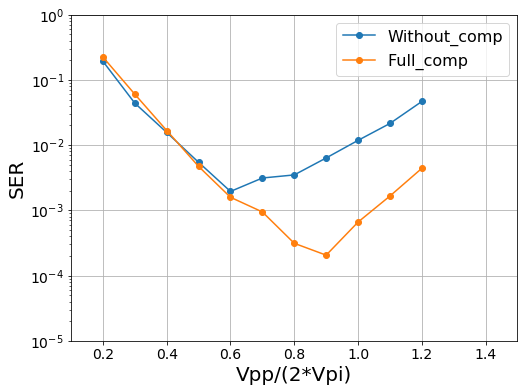

In [13]:
vpp_arr = np.linspace(0.2, 1.2, 11)*7
figure(figsize=(8,6))
plot(vpp_arr/7, SER_pilot_ori[0,:], '-o', label='Without_comp')
plot(vpp_arr/7, SER_arr_comp[0,:], '-o', label='Full_comp')
xlim(0.1, 1.5)
ylim(1e-5,1e0)
yscale('log')
legend(fontsize=16)
xticks(fontsize=14)
yticks(fontsize=14)
xlabel('Vpp/(2*Vpi)',fontsize=20)
ylabel('SER',fontsize=20)
grid()
show()